# Writing A Data Science Blog Post
## 

### By: David Herr
### Dated: August 2nd, 2020

A Jupyter notebook aimed to complete the Udacity Data Science Nanodegree Project 1. In the project, students are to use the CRISP-DM process to understand, prepare, model, and evaluate data to answer real-world business questions.

First, we'll bring in the packages used to complete the project.

In [9]:
# data import and manipulation 
import numpy as np
import pandas as pd

# plotting and graphing
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# text analysis, mining, and sentiment
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# linear regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# custom modules
import fns_DataVisualization as viz
import fns_DataWrangling as wrngl

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dlher\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dlher\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dlher\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### 1) Pick A Dataset

Although the traditional CRISP-DM path is to start with business questions, the Udacity Data Science program provided datasets to start with. Thus, we'll start with those datasets and read them in to the notebook.

In [10]:
# Read in Boston dataset
df_boston = pd.read_csv('./_data/listings_boston.csv')

# Read in Seattle dataset
df_seattle = pd.read_csv('./_data/listings_seattle.csv')

### 2) Pose 3-5 Business Questions
Leveraging this data, we are curious to find out if:

    1. Bedroom or Bathroom count generally correlates to higher pricing?
    2. Are there certain neighborhoods which command generally higher pricing?
    3. Does containing a top N keyword in descriptions result in higher pricing?
    4. Are ratings predictive of pricing?

In [ ]:
#### 3) Use CRISP_DM 
To answer these questions, we'll use what is known as the CRISP_DM process. This process is pictated below:

![Image of CRISP_DM](_img\CRISP_DM.png)


##### 3.1) Business Understanding

**Boston Bed/Bath Analysis**
***

<module 'matplotlib.pyplot' from 'C:\\Users\\dlher\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

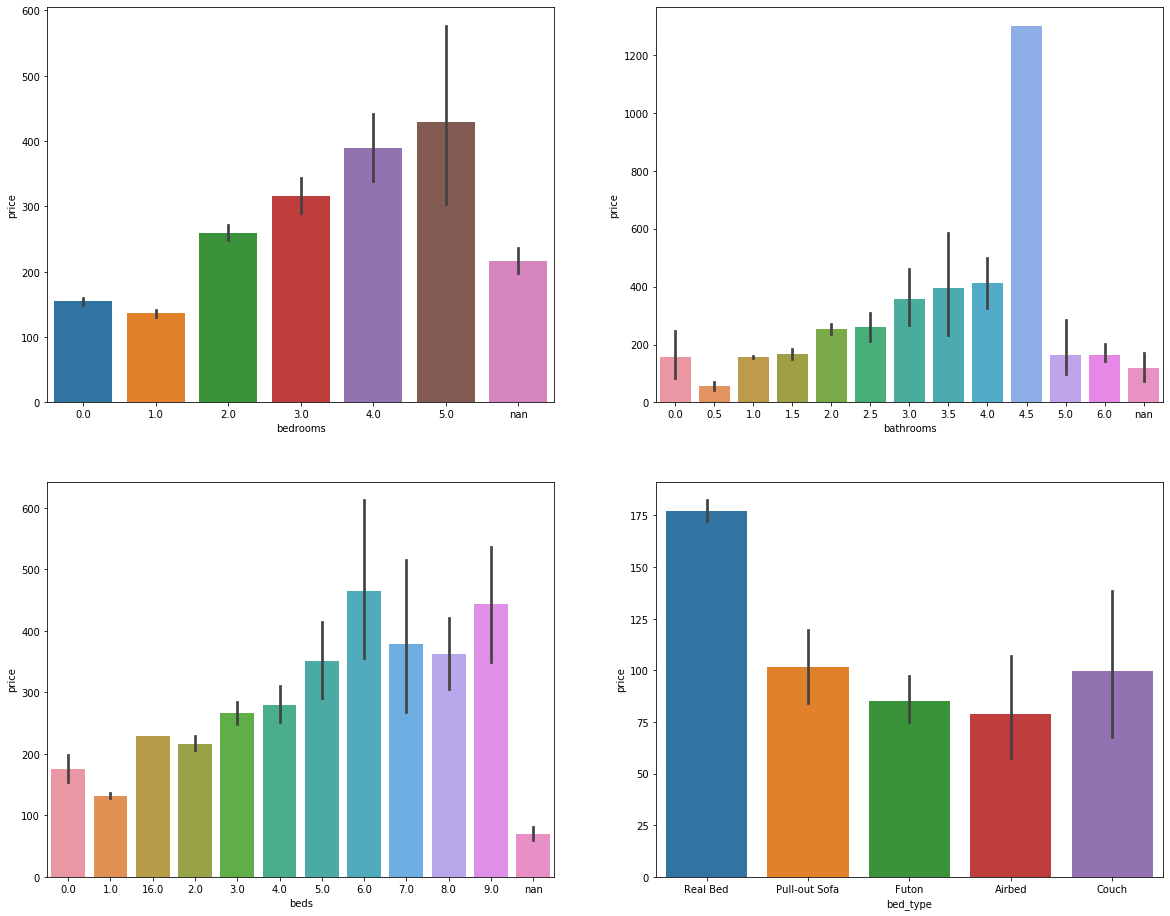

In [12]:
# define columns to be used for price vs. bed/bath analysis
bed_bath_cols = ['price','bedrooms','bathrooms','beds','bed_type']

# call 2x2 price analysis plot for all bed/bath cols (Boston)
viz.price_analysis_plots(df_boston[bed_bath_cols])

**Boston Neighborhood Analysis**
***

<module 'matplotlib.pyplot' from 'C:\\Users\\dlher\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

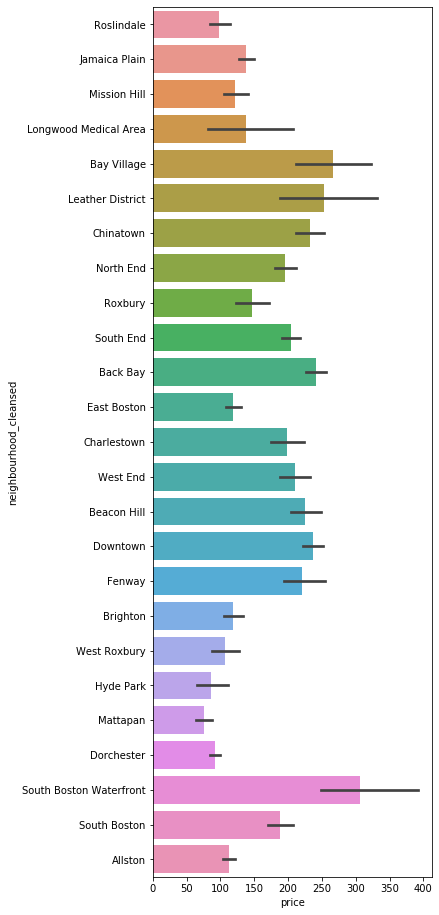

In [11]:
# define columns to be used for price vs. neighbourhood analysis
neighborhood_cols = ['price','neighbourhood_cleansed']

# call 1x1 price analysis plot for neighborhoods cols (Boston)
viz.price_analysis_plots(df_boston[neighborhood_cols], False)

##### 3.2) Data Understanding

While the head() method is useful, a more thorough understanding of all the available columns, datatypes, as well as profile of that data, is necessary before moving on to preparing the data for modeling.

In [ ]:
# To be able to understand both datesets quickly, let's put them into a list
df_list = [df_boston,df_seattle]

# And see the overall shape of each data frame, column names, and column data types
for dataframe in df_list:
    print("Dataframe Shape:{}".format(dataframe.shape))
    for col in dataframe:
        print("{}:{}".format(col,dataframe[col].dtypes))

##### 3.3) Data Preperation
In this section, we will be using our above observations to guide both the initial cleansing of our data, as well as initial transformations for feature creation.

**Column Cleansing**
***

We'll start with the data cleansing process on the columns. This will largely involve removing:

- [x]  100% empty
- [x]  Columns with 100% of the same value
- [x]  Database identifications
- [x]  Non-overlapping columns

In [ ]:
# Start with dropping columns in all data sets that are 100% na
for dataframe in df_list:
    dataframe.dropna(axis = 1, how = 'all',inplace = True)

In [ ]:
# Remove the unnecssary id, url, and scraping columns
def drop_ident_columns(dataframe_list,word_list):
    for dataframe in dataframe_list:
        for word in word_list:
            drop_columns = [col for col in dataframe.columns if col.endswith(word)]
            dataframe.drop(drop_columns, axis = 1,inplace = True)

# Define search words to drop common identification column suffixes
search_words = ['_id','_url','_scraped']

# Invoke function to drop id, url, and scraping columns
drop_ident_columns(df_list,search_words)

In [ ]:
# Remove columns where all values are the same (equivalant of 100% empty)
def drop_same_columns(dataframe_list):
    for dataframe in dataframe_list:
        nunique = dataframe.apply(pd.Series.nunique)
        drop_columns = nunique[nunique ==1].index
        dataframe.drop(drop_columns, axis = 1,inplace = True)

# Invoke function to drop any columns containing rows with 100% the same data point
drop_same_columns(df_list)

In [ ]:
# Drop columns which do not overlap between the two datasets
def drop_nonoverlap_columns(df1,df2):
    # Find overlapping/instersecting columns between the two datasets
    intersecting_columns = set(df1.columns) & set(df2.columns)

    # Assign each dataset it's own drop columns based off the complete list of intersections
    for dataframe in df1, df2:
        drop_columns = set(dataframe.columns) - intersecting_columns
        dataframe.drop(drop_columns, axis = 1, inplace = True)

# Invoke function to drop non-overlapping columns between two datasets    
drop_nonoverlap_columns(df_boston,df_seattle)

# Check to make sure all columns are overlapping between dataframes
sum((df_boston.columns == df_seattle.columns)) / ((len(df_boston.columns) + len(df_seattle.columns)) / 2 ) == 1

**Row & Data Cleansing**
***
Next, we'll move into basic *row cleansing* for items we know will break a linear regression model. This includes:

- [x]  True/False - transform to a true boolean rather than text "t" or "f".
- [x]  Substantial Text - must be transformed into a text analytics feature.
- [ ]  Date Columns - drop or transform into a duration if business questions warrant.

In [ ]:
# Function to clean t/f columns to true Booleans
def cleanse_data_tf_to_boolean(dataframe_list):

    for dataframe in dataframe_list:

        column_list = []

        for col in dataframe.columns:
            if sum(dataframe[col].isin(['t','f'])) == len(dataframe[col]):
                column_list.append(col)

        for col in column_list:
            dataframe.loc[(dataframe[col] == 't'),col] = True
            dataframe.loc[(dataframe[col] == 'f'),col] = False

# Invoke function to change 't' or 'f' to true Boolean values
cleanse_data_tf_to_boolean(df_list)

In [ ]:
#  Define text columns which require processing for text analytics
text_cols = ['name','summary','space','description','neighborhood_overview', 'notes']

# Begin text mining by defining stop words and lemmatizer dictionary
stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

# Function to perform basic tokenization of text columns
def tokenize(text):
    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    # tokenize text
    tokens = word_tokenize(text)
    
    # lemmatize andremove stop words
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return tokens

# Loop through dataframes and text cols to tokenize
def tokenize_text_cols(dataframe_list):

    for dataframe in dataframe_list:
        for col in text_cols:
            colname = col + '_tokenized'
            dataframe[colname] = dataframe[col].apply(str).apply(tokenize)

# Invoke tokenization as add columns in both dataframes
tokenize_text_cols(df_list)

In [ ]:
# initialize count vectorizer object
vectorizer = CountVectorizer(tokenizer=tokenize)

# get counts of each token (word) in text data
top_vocab = vectorizer.fit_transform(df_boston['summary'].apply(str))

# Create dataframe to hold vocabulary and count of each item
top_vocab_df = pd.DataFrame((count,word) for word, count in zip(sum(top_vocab.toarray()).tolist(),vectorizer.get_feature_names()))

# Assign column names to new dataframe
top_vocab_df.columns = ['Word', 'Count']

# Sort descending to see top words
top_vocab_df.sort_values('Count', ascending=False, inplace=True)

# Preview results of dataframe
top_vocab_df.head(20)


In [ ]:
# Convert the top 20 words to a list for feature extraction
top_vocab_df.nlargest(20,'Count')['Word'].tolist()

##### 3.4) Data Modeling

[Outline placeholder for data modeling section]

##### 3.5) Results Evaluation

[Outline placeholder for evaluation of model and possible re-modeling]

##### 3.6) Deployment

[Outline placeholder for what deployment steps would be]

#### 4. Conclusion

[Outline placeholder for final remarks]